# Notebook 7: Aprendizaje por refuerzo - Métodos Montecarlo

En este notebook profundizaremos en los métodos de control del aprendizaje por refuerzo. En particular, nos centraremos en métodos tabulares que no necesitan disponer de un modelo de cómo funciona el entorno.

Trabajaremos nuevamente con [Gym](https://www.gymlibrary.dev/), aunque esta vez utilizaremos el entorno [`Blackjack-v1`](https://gymnasium.farama.org/environments/toy_text/blackjack/#blackjack) que, como su nombre indica, simula una partida de Blackjack.

>
>  *¿Qué es el Blackjack?*
>
>Según [Wikipedia](https://es.wikipedia.org/wiki/Blackjack): "El blackjack, también llamado veintiuno, es un juego de cartas, propio de los casinos con una o más barajas inglesas de 52 cartas sin los comodines, que consiste en sumar un valor lo más próximo a 21 pero sin pasarse. En un casino cada jugador de la mesa juega únicamente contra el crupier, intentando conseguir una mejor jugada que este. El crupier está sujeto a reglas fijas que le impiden tomar decisiones sobre el juego. Por ejemplo, está obligado a pedir carta siempre que su puntuación sume 16 o menos,diciendo siempre empieza la mano y obligado a plantarse si suma 17 o más. Las cartas numéricas suman su valor, las figuras suman 10 y el As vale 11 o 1, a elección del jugador. En el caso del crupier, los Ases valen 11 mientras no se pase de 21, y 1 en caso contrario. La mejor jugada es conseguir 21 con solo dos cartas, esto es con un As más carta de valor 10. Esta jugada se conoce como Blackjack o 21 natural. Un Blackjack gana sobre un 21 conseguido con más de dos cartas."

En este caso, el entorno de OpenGym simula una partida de un solo jugador contra el crupier. Además de lo descrito anteriormente, debes saber que el agente conoce el valor de la primera carta del crupier, pero no del resto de cartas del crupier.

Carguemos el entorno y explorémoslo brevemente.

In [1]:
# Si los paquetes no están instalados, hay que ejecutar estas líneas:
#!pip install gymnasium
import gymnasium as gym
import numpy as np
env = gym.make('Blackjack-v1', render_mode='rgb_array')

Examinando las propiedades y métodos del objeto `env` con `dir()` podemos comprobar que hay dos variables que nos dan toda la información que necesitamos respecto al estado:
 - `env.player`: registra las cartas que tiene el jugador.
 - `env.dealer`: registra las cartas que tiene el crupier. Esta información no estará disponible para el agente.

Puedes acceder a estas variables como `env.get_wrapper_attr('dealer')` y `env.get_wrapper_attr('player')` respectivamente.
  
Podemos probar, además, a mostrar el entorno con el método render. Al haber definido el `render_mode` como `rgb_array`, podemos utilizar `matplotlib` para mostrarlo. Definiremos para ello una función llamada `muestra_entorno`. 

La lista de acciones se encuentra en `env.action_space`. Se trata de un objeto de tipo `Discrete(2)`, lo que nos indica que hay dos acciones diferentes, identificadas con 0 y 1.

[10, 10]
[3, 10]


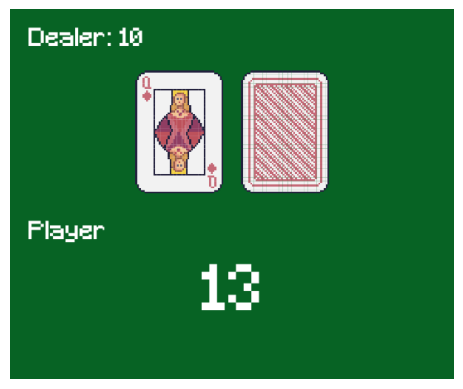

<class 'gymnasium.spaces.discrete.Discrete'>
Hay 2 acciones


In [6]:
env.reset()

print(env.get_wrapper_attr('dealer'))
print(env.get_wrapper_attr('player'))

import matplotlib.pyplot as plt
def muestra_entorno(env:gym.Env) -> None:
    plt.imshow(env.render())
    plt.axis('off')
    plt.show()

# Probamos el método para mostrar el entorno
muestra_entorno(env)

# Muestra las acciones disponibles
acciones = env.action_space
print(type(acciones))
print(f'Hay {acciones.n} acciones')

Podemos comprobar que hay dos acciones distintas. Vamos a ejecutar las acciones 0 y 1 para comprobar su efecto y examinar las variables que nos devuelve.

In [16]:
env.reset()

print('Situación antes:')
print('Crupier:', env.get_wrapper_attr('dealer'))
print('Jugador:', env.get_wrapper_attr('player'))

# TODO - Cambia la acción a 0 o 1 y ejecuta la celda las veces que necesites hasta que identifiques qué acción corresponde con 0 y cuál con 1.
accion = 1
obs, reward, terminated, truncated, info = env.step(accion)

print('Obs:', obs)
print('Reward:', reward)
print('Terminated:', terminated)
print('Truncated:', truncated)
print('Info:', info)

print('Situación después:')
print('Crupier:', env.get_wrapper_attr('dealer'))
print('Jugador:', env.get_wrapper_attr('player'))

# TODO - Indica qué acción es 0 y cuál es 1.
PLANTARSE = 0
PEDIR_CARTA = 1

Situación antes:
Crupier: [3, 10]
Jugador: [10, 2]
Obs: (17, 3, 0)
Reward: 0.0
Terminated: False
Truncated: False
Info: {}
Situación después:
Crupier: [3, 10]
Jugador: [10, 2, 5]


### Representación del problema

Además de identificar las acciones, hemos podido comprobar lo siguiente:
 - En `obs` está toda la información que necesita el agente. Se trata de una terna que indica, por este orden, la puntuación del jugador, la puntuación **visible** del crupier (solo su primera carta) y un booleano que indica si el jugador dispone de un as (que es especial porque puede contar 1 u 11).
 - `terminated` es True cuando termina la partida, es decir, cuando el jugador se planta o cuando pide una carta y se pasa de 21.
 - `reward` es -1 cuando el jugador pierde la partida (el crupier obtuvo un valor más cerca de 21 sin pasarse) y 1 cuando el jugador gana (situación inversa). Es 0 en cualquier otro caso.
 
Por tanto, podemos representar los estados con la terna que nos ofrece la observación.

Estado(puntuacion_jugador=11, puntuacion_visible_crupier=10, jugador_con_as=0)


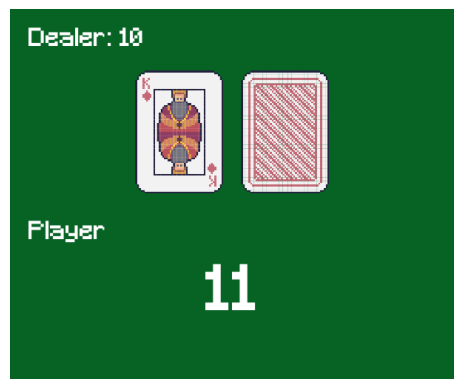

((17, 10, 0), {})

In [17]:
from collections import namedtuple

# Representaremos los estados como tuplas con los siguientes campos con nombre:
#  - puntuacion_jugador: Representa la suma de los valores de las cartas recibidas
#  - puntuacion_visible_crupier: Representa la suma de las cartas visibles del crupier
#  - jugador_con_as: Booleano que indica si el jugador tiene un as
Estado = namedtuple('Estado', ['puntuacion_jugador', 'puntuacion_visible_crupier', 'jugador_con_as'])

# TODO - Completa la función
def get_estado(obs:tuple[int, int, int]) -> Estado:
    pj, pvc, a = obs
    return Estado(puntuacion_jugador=pj,puntuacion_visible_crupier=pvc, jugador_con_as=a)

# COMPROBACIONES - TODO - Verifica que el estado que se imprime coincide con lo mostrado en la imagen
env.reset()
obs = env.step(PLANTARSE)[0]
estado = get_estado(obs)
print(estado)
muestra_entorno(env)
env.reset()

### Ausencia de modelo del entorno

Este problema es no determinista, es decir, aplicar una acción a un estado fijo no siempre da los mismos resultados. Veamos un ejemplo:
> Supongamos que estamos en el estado $s=$(17, 1, True). Esto quiere decir lo siguiente:
> - El crupier tiene un as (y otra carta que el agente no puede ver)
> - El jugador tiene un as y un 6.
> En esta situación, supongamos que el agente ejecuta la acción $a=$PLANTARSE. Hay dos posibilidades:
> - El crupier acaba sumando más de 17 (pero menos de 22), así que gana. `reward` será $r=-1$ y el estado resultante  será $s'=$(17,X,True) con $X \in [18,21]$.
> - El crupier acaba pasándose, así que gana el agente. `reward` será $r=1$ y el estado será $s'=$(17,X,True) con $X > 21$.
> De la misma manera, si el agente eligiese $a=$PEDIR_CARTA, el estado y la reward dependerían del azar.

Dicho de otra manera, el agente no dispone de $p(s',r | s,a)$.

## Definición de políticas

Vamos a definir una política aleatoria, es decir, que para cada para estado $s$ otorgue la misma probabilidad $\pi(a|s)$ a cualquiera de las dos acciones. Para ello, siguiendo lo hecho en el notebook 6, declararemos un `numpy.array` que registre, para cada par estado-acción $s,a$, la probabilidad $\pi(a|s)$ (que será la misma siempre).

In [77]:
# TODO - Inicializa la policy
politica_aleatoria = np.zeros((12,10,2,2))
politica_aleatoria[:] = 0.5

# TODO - Recupera la función sample_policy del notebook 6 y adáptala para que devuelva el número de la acción
...
def muestrea_politica(estado:Estado, politica:np.ndarray) -> int:
    # Obtenemos la distribución de probabilidad
    probs = politica[estado.puntuacion_jugador -11, estado.puntuacion_visible_crupier -1, estado.jugador_con_as, :]
    # Comprobación de que la política está bien (se puede comentar cuando estemos seguros de que es así)
    np.testing.assert_almost_equal(np.sum(probs), 1.0, err_msg='La política para un estado siempre debe sumar 1')
    # Devolvemos una acción aleatoria muestreada según las probabilidades indicadas por la política
    return np.random.choice([0,1], p=probs)
    

# COMPROBACIONES
assert(politica_aleatoria[1,1,1,1]==0.5)

In [45]:
muestrea_politica(Estado(5,2,0), politica_aleatoria)

1

Vamos a definir además una función para poder visualizar la política cómodamente. Para cada estado, nos indicará con un color si la acción a tomar será PLANTARSE o PEDIR CARTA.

In [39]:
x_range = np.arange(1, 11)
y_range = np.arange(11, 22)
X, Y = np.meshgrid(x_range, y_range)
Y[0,0]=0
Y[::-1], Y

(array([[21, 21, 21, 21, 21, 21, 21, 21, 21, 21],
        [20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
        [19, 19, 19, 19, 19, 19, 19, 19, 19, 19],
        [18, 18, 18, 18, 18, 18, 18, 18, 18, 18],
        [17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
        [16, 16, 16, 16, 16, 16, 16, 16, 16, 16],
        [15, 15, 15, 15, 15, 15, 15, 15, 15, 15],
        [14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
        [13, 13, 13, 13, 13, 13, 13, 13, 13, 13],
        [12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
        [ 0, 11, 11, 11, 11, 11, 11, 11, 11, 11]]),
 array([[ 0, 11, 11, 11, 11, 11, 11, 11, 11, 11],
        [12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
        [13, 13, 13, 13, 13, 13, 13, 13, 13, 13],
        [14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
        [15, 15, 15, 15, 15, 15, 15, 15, 15, 15],
        [16, 16, 16, 16, 16, 16, 16, 16, 16, 16],
        [17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
        [18, 18, 18, 18, 18, 18, 18, 18, 18, 18],
        [19, 19, 19, 19, 19, 19, 19, 19, 19, 19]

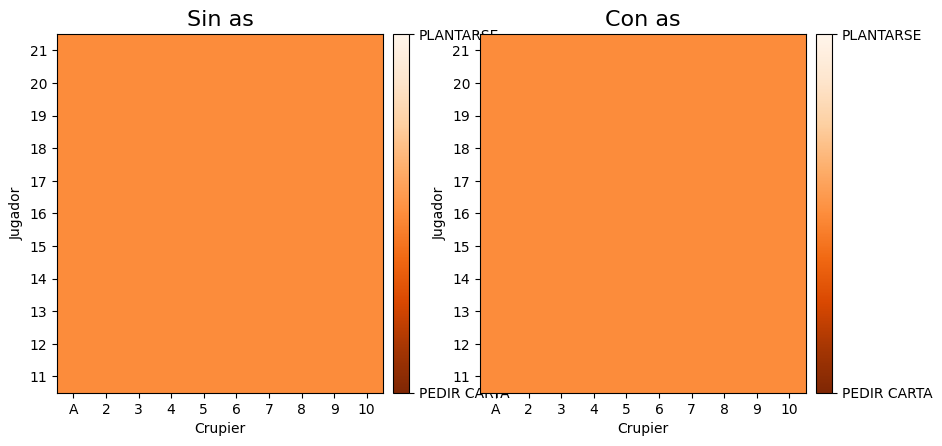

In [51]:
# Función para mostrar la política
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
def dibuja_politica(politica: np.ndarray) -> None:
    def crea_figura(con_as: bool, ax:Axes):
        x_range = np.arange(1, 11)
        y_range = np.arange(11, 22)
        X, Y = np.meshgrid(x_range, y_range)
        Z = politica[Y[::-1] - min(y_range),X -min(x_range) ,1 if con_as else 0,1]
        surf = ax.imshow(Z, cmap=plt.get_cmap('Oranges'), vmin=0, vmax=1, extent=[0.5, 10.5, 10.5, 21.5])
        plt.xticks(x_range, ('A', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
        plt.yticks(y_range)
        ax.set_xlabel('Crupier')
        ax.set_ylabel('Jugador')
        #ax.grid(color='black', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0, 1], cax=cax)
        cbar.ax.set_yticklabels(['PLANTARSE','PEDIR CARTA'])
        cbar.ax.invert_yaxis() 
            
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(121)
    ax.set_title('Sin as', fontsize=16)
    crea_figura(False, ax)
    ax = fig.add_subplot(122)
    ax.set_title('Con as', fontsize=16)
    crea_figura(True, ax)
    plt.show()
    
# TODO - Muestra la política aleatoria declarada antes usando la función recién definida
dibuja_politica(politica_aleatoria)

Como la política es aleatoria, se muestra con un color intermedio para cualquier estado.

### Uso de la política

Vamos a adaptar la función que genera un episodio siguiendo una política preestablecida, desarrollada en el notebook 6. Para los métodos Montecarlo necesitaremos registrar la secuencia $S_0,A_0,R_1,S_1,A_1,R_2...S_{T-1},A_{T-1},R_T$ de estados recorridos, acciones aplicadas y recompensas recibidas, así que deberemos adaptar la implementación.

In [ ]:
def simula_episodio(politica:np.ndarray, muestra_renders:bool=False, imprime:bool=False) -> tuple[float, int]:
    env.reset()
    # TODO - Adapta el bucle que escribiste 3 celdas de código más arriba para que use la política para decidir qué acción tomar en cada paso
    completado = False
    contador = 0
    ret = 0
    while not completado:
        estado_actual = get_estado(env)
        accion = muestrea_politica(estado_actual,politica)
        observacion = env.step(accion)
        completado = observacion[2]
        ret += observacion[1]
        if imprime:
            print(f'Paso {contador}, accion {accion}, x: {estado_actual.x}, y {estado_actual.y}, dir {estado_actual.dir}')
        #im = plt.imshow(env.render())
        #plt.show()
        contador+=1
    
    return (ret, contador)

In [80]:
# TODO - Recupera la función simula_episodio del notebook 6 y haz las modificaciones necesarias para que funcione en este problema.
# Además, la función deberá ahora devolver también una lista de tuplas con los estados recorridos, acciones aplicadas y recompensas recibidas.
def simula_episodio(politica:np.ndarray, muestra_renders:bool=False, imprime:bool=False) -> tuple[float, int, list[tuple[Estado, int, float]]]:
    env.reset()
    completado = False
    contador = 0
    ret = 0
    recorrido = []

    obs, reward, terminated, truncated, info = env.step(0)
    estado_actual = get_estado(obs)
    
    while not completado:
        
        accion = muestrea_politica(estado_actual,politica)
        obs, reward, terminated, truncated, info = env.step(accion)
        estado_actual = get_estado(obs)
        if estado_actual.puntuacion_jugador > 10: 
            estado_actual = Estado(11,estado_actual.puntuacion_visible_crupier,estado_actual.jugador_con_as)
        completado = terminated
        ret += reward
        if imprime:
            print(f'Paso {contador}, accion {'plantarse' if not accion else 'pedir'}, jugador: {estado_actual.puntuacion_jugador +1}, crupier {estado_actual.puntuacion_visible_crupier +11}, as {estado_actual.jugador_con_as}')
        recorrido.append((estado_actual, accion, reward))
        #im = plt.imshow(env.render())
        #plt.show()
        contador+=1
    return (ret, contador, recorrido)

retorno, num_pasos, recorrido = simula_episodio(politica_aleatoria, imprime=True)

print('Recorrido:', recorrido)

Paso 0, accion pedir, jugador: 12, crupier 21, as 0
Recorrido: [(Estado(puntuacion_jugador=11, puntuacion_visible_crupier=10, jugador_con_as=0), 1, -1.0)]


### Comprobación del rendimiento de la política

Hagamos un experimento para evaluar la eficacia de la política aleatoria. Simularemos 200 episodios, anotando los retornos obtenidos en cada uno.

Mostraremos estadísticas y gráficos que nos puedan ayudar a tener una idea de cómo de bien funciona.

In [60]:
# TODO - Recupera la función comprueba política del lab4
# Modifícala para que registre y muestre las recompensas en lugar del número de pasos
# y úsala para probar la política aleatoria
def comprueba_politica(politica:np.ndarray, imprime:bool = False) -> None:
    episodios_pasos = []
    episodios_recompensas = []
    for i in range(200):
        retorno, num_pasos, recorrido = simula_episodio(politica_aleatoria, imprime=False)
        episodios_pasos.append(num_pasos)
        episodios_recompensas.append(retorno)
        if imprime: print(f'{i} - Simulado un episodio con retorno {retorno} ({num_pasos})')
   

    assert(len(episodios_pasos)==200)
    
    # Mostramos un histograma para la duración de los episodios
    #plt.hist(episodios_pasos)
    #plt.hist(episodios_recompensas)
    #plt.show()

    # Mostramos también un diagrama de caja
    #plt.boxplot(episodios_pasos)
    #plt.boxplot(episodios_recompensas)
    #plt.show()

    # Por último, escribimos un par de estadísticas
    #print('Se han necesitado de media',np.mean(episodios_pasos),'pasos (+-',np.std(episodios_pasos),')')
    #print('El episodio más corto duró',np.min(episodios_pasos),'pasos y el episodio más largo duró',np.max(episodios_pasos),'pasos')
    
    
# Comprueba los retornos de la política aleatoria usando la función recién declarada
comprueba_politica(politica_aleatoria,False)

Podrás comprobar que si se juega al Blackjack siguiendo una política aleatoria, la expectativa es que se va a perder bastante dinero.

## Evaluación de políticas

Para poder mejorar la política aleatoria en el notebook 6 determinábamos el valor $v_\pi(s)$ de cada estado y, en función de él, desde cualquier estado $s$ elegíamos la acción que nos dirigía al estado que mayor retorno obtuviese. Sin embargo, para poder hacer eso a partir de $v_\pi(s)$, es necesario conocer $p(s',r|s,a)$, y ese no es el caso en este problema. Si no sabemos a qué estado $s'$ conduce cada acción $a$, no podemos elegir la acción $a$ que dé más retorno.

Por ello, los métodos Montecarlo optan por estimar $q_\pi(s,a)$ o, lo que es lo mismo, el retorno esperado aplicando la política $\pi$ de aplicar la acción $a$ en el estado $s$.

Implementemos el siguiente algoritmo, pero calculando $q_\pi(s,a)$ además de $v_\pi(s)$.

![MC prediction](https://github.com/eirasf/GCED-AA3/blob/main/lab5/img/montecarlo-evaluation-algorithm.png?raw=true)

In [82]:
GAMMA = 1.0 # En este problema no descontaremos las recompensas futuras a la hora de calcular el retorno

def mc_evaluate(politica:np.ndarray, iteraciones:int = 2000) -> tuple[np.ndarray, np.ndarray]:
    #Initialize
    # TODO - Indica la shape del array que almacena v(s) para cada estado s
    vs = np.zeros((11,10,2))
    # TODO - Indica la shape del array que almacena q(s,a) para cada par s,a
    qsa = np.zeros((11,10,2,2))
    
    # En returns tendremos una lista de retornos (inicialmente vacía) por cada par s,a
    retornos = []
    # Creamos la estructura
    for i in range(qsa.shape[0]):
        r_i = []
        for j in range(qsa.shape[1]):
            r_j = []
            for k in range(qsa.shape[2]):
                r_k = []
                for l in range(qsa.shape[3]):
                    r_k.append([])
                r_j.append(r_k)
            r_i.append(r_j)
        retornos.append(r_i)
        
    # Loop
    # Bucle principal del algoritmo (solo el número de iteraciones que se haya indicado por parámetro) adaptándolo para calcular q(s,a) siguiendo la policy
    for i in range(iteraciones):
        # TODO - Obtén los valores de un episodio simulado siguiendo la policy
        ep_retorno, ep_num_pasos, ep_recorrido = simula_episodio(politica_aleatoria, imprime=False)
        g = 0
        estados_restantes:list[Estado] = []
        for estado, _, _ in ep_recorrido:
            estados_restantes.append(estado)
        
        for estado, accion, recompensa in reversed(ep_recorrido):
            estados_restantes.pop()
            # TODO - Actualiza g según dicta el algoritmo
            g = GAMMA*g + recompensa 
            if estado not in estados_restantes:
                # TODO - Añade g a los retornos de este par estado-acción (calcularemos todas las medias al final)
                #print(estado)
                retornos[estado.puntuacion_jugador-11][estado.puntuacion_visible_crupier-1][estado.jugador_con_as].append(g) 
    
    # Ahora calculamos los retornos medios
    for i in range(qsa.shape[0]):
        for j in range(qsa.shape[1]):
            for k in range(qsa.shape[2]):
                for l in range(qsa.shape[3]):
                    qsa[i,j,k,l] = np.mean(retornos[i][j][k][l])
                    vs[i,j,k] += politica[i,j,k,l] * qsa[i,j,k,l]
                    
    return qsa, vs

q_values_aleatoria, v_values_aleatoria = mc_evaluate(politica_aleatoria)

Vamos a representar el valor de cada estado en una gráfica para visualizarlo cómodamente.

TypeError: Input z must be at least a (2, 2) shaped array, but has shape (10, 1)

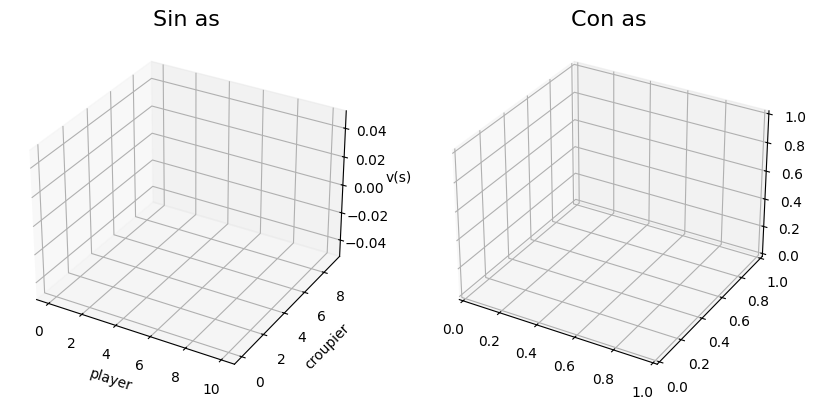

In [83]:
# Vamos a representar en una gráfica v(s) para cada estado s
from mpl_toolkits import mplot3d

def dibuja_vs(vs:np.ndarray) -> None:
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(121, projection='3d')
    ax.set_title('Sin as', fontsize=16)
    x = np.arange(vs.shape[0])
    y = np.arange(vs.shape[1])

    X, Y = np.meshgrid(x, y)
    sin_ases = vs[X,Y,0]
    ax.contour3D(X, Y, sin_ases, 50, cmap='binary')
    ax.set_xlabel('player')
    ax.set_ylabel('croupier')
    ax.set_zlabel('v(s)');
    

    ax = fig.add_subplot(122, projection='3d')
    ax.set_title('Con as', fontsize=16)
    
    x = np.arange(10,vs.shape[0])
    y = np.arange(vs.shape[1])
    X, Y = np.meshgrid(x, y)
    con_ases = vs[X,Y,1]
    ax.contour3D(X, Y, con_ases, 50, cmap='binary')
    ax.set_xlabel('player')
    ax.set_ylabel('croupier')
    ax.set_zlabel('v(s)');

    plt.show()
    
dibuja_vs(v_values_aleatoria)

En las gráficas se puede apreciar lo siguiente:
 - Los valores asignados son 'irregulares', en el sentido de que estados contiguos tienen valores dispares y no hay una tendencia uniforme. Este efecto se debe a que $v_\pi(s)$ se está estimando en función de los episodios que han recorrido el estado $s$; cuando el estado se recorre pocas veces, la estimación es poco fiable. Es por ello que el efecto se reduce si aumentamos el número de iteraciones.
 - La gráfica 'Con as' es más irregular que la 'Sin as'. Reflexionando un poco, podemos darnos cuenta de que las partidas en las que el jugador tiene un as son infrecuentes, con lo cual las estimaciones se hacen a partir de un número menor de muestras y, por tanto, son menos fiables.
 - Siguiendo la política aleatoria, los valores son más altos cuanto más cerca está el jugador de 21.

Examinemos ahora nuestra estimación de $q_\pi(s,a)$. Para ello miremos solo el valor para los estados en que el jugador tiene cartas que suman 8 (sin tener un as).

In [ ]:
print(q_values_aleatoria[8,:,0,:])

Podemos ver, para cada posible estado de las cartas del croupier, el valor de ejecutar, respectivamente, las acciones PLANTARSE y PEDIR CARTA, siguiendo después la política aleatoria.

Es de esperar que muchas de las estimaciones de $q_\pi(s,a)$ de que disponemos sean aún menos precisas que las de $v_\pi(s)$, debido al bajo número de muestras.


### Mejora de la política

Ahora que disponemos del valor de $q_\pi(s,a)$ (aunque sea una mala estimación), podemos mejorar la política aleatoria y conseguir una política $\pi'\geq\pi$ simplemente haciendo una selección *avara (greedy)* del valor $q_\pi(s,a)$ para todas las acciones $a$ disponibles desde cualquier estado $s$. 

Implementemos esta mejora de la política.

In [ ]:
# TODO - Recupera la función greedify_policy del notebook 6 y adáptala para que trabaje con q(s,a) en lugar de v(s)
def crea_politica_avara(q_values: np.ndarray) -> np.ndarray:
    ...

# Calculamos la nueva política a partir de los q_values que habíamos aproximado para la política aleatoria
politica_mejorada = crea_politica_avara(q_values_aleatoria)
dibuja_politica(politica_mejorada)
comprueba_politica(politica_mejorada)

Se puede comprobar que la nueva política obtiene mejores resultados que la política aleatoria. Sin embargo, al visualizarla observamos que es bastante 'irregular', lo cual era de esperar conociendo el problema que tenían nuestras estimaciones de $q_\pi(s,a)$ (que utilizamos como fundamento para elegir la nueva política).

### Mejoras sucesivas

En el notebook 6, repetíamos este ciclo de evaluación de la política para obtener $v_\pi(s)$, a partir del cual obtener una $\pi'$ mejor, volver a evaluarla para obtener $v_{\pi'}(s)$ y a partir de ella obtener una $\pi''$ todavía mejor... y continuábamos este proceso mientras la política seguía mejorando.

![Policy iteration](https://github.com/eirasf/GCED-AA3/blob/main/lab5/img/policy-iteration.png?raw=true)

Podríamos intentar ese mismo proceso en este caso, pero hay un problema importante.

Supongamos que nuestra política decide que para $s=[19, 7, 1]$ la acción $a$ que debe tomar es PLANTARSE. Al simular un episodio siguiendo esa política, **¡no estaremos tomando ninguna muestra del retorno de usar PEDIR CARTA en ese estado!**. Dicho de otra manera, tendremos una buena estimación de $q_\pi([19, 7, 1], $PLANTARSE$)$, pero no tendremos estimación de $q_\pi([19, 7, 1], $PEDIR CARTA$)$. Por tanto, no podremos calcular cuál es la mejor acción, es decir, $\pi'([19, 7, 1]) = arg\max_{a'} q_\pi([19, 7, 1], a')$ y nuestra iteración de políticas se vería trucada.

Esta es una manifestación del problema de **exploración vs. explotación** con la que se deben enfrentar los métodos de Montecarlo. Existen varias soluciones:
 - **Exploring starts**: Seleccionar el primer estado y la primera acción aleatoriamente (sin atender a la política) de entre las disponibles.
 - **Uso de políticas estocásticas**: mantener un nivel de aleatoriedad en la política para que explore algunas veces (políticas *$\epsilon$-soft*).
 - **Exploración off-policy**: uso de una política para las simulaciones distinta de la que se está aprendiendo.
 
En este notebook utilizaremos la segunda solución. Haremos las simulaciones siguiendo la política *greedy*, pero que tendrá una probabilidad $\epsilon$ de tomar una acción aleatoria. Además, para acelerar el cálculo, haremos la evaluación y la mejora de la política en el mismo algoritmo (de manera similar a como ocurría en el algoritmo de iteración de valores visto en el notebook 6). El algoritmo a seguir es muy similar al algoritmo de evaluación visto anteriormente y está descrito a continuación:

![Montecarlo ES](https://github.com/eirasf/GCED-AA3/blob/main/lab5/img/mc-control-algorithm.png?raw=true)

In [ ]:
# TODO - Implementa la función basándote en la descripción del algoritmo (es muy similar a la función mc_evaluate vista más arriba)
def mc_control(num_pasos:int=100000, epsilon:float=0.2) -> np.ndarray:
    qsa = np.zeros(...)
    politica = np.zeros(...)
    # Partimos de la política aleatoria
    politica[:] = 1.0 / NUM_ACCIONES
    
    ...
    
    return crea_politica_avara(politica)

# Calculamos la política usando un epsilon de 0.4 para garantizar la exploración
politica_montecarlo_es = mc_control(epsilon=0.4)
dibuja_politica(politica_montecarlo_es)
comprueba_politica(politica_montecarlo_es)

La política obtenida es mucho mejor, aproximándose ya a la política óptima para este problema. Prueba distintos valores de `epsilon` o de `num_pasos` para intentar conseguir una política aún mejor.

### Política óptima

Como referencia, vamos a aplicar la política que se describe en el libro "Reinforcement Learning: An Introduction" como óptima para este problema (calculada tras un alto número de iteraciones del algoritmo Montecarlo Exploring Starts, similar al que hemos aplicado nosotros).

In [ ]:
HIT = [0.0, 1.0]
STICK = [1.0, 0.0]
barto = np.zeros(politica_montecarlo_es.shape)
barto[:] = 0.5

cutoffs0=[16,12,12,11,11,11,16,16,16,16]
cutoffs1=[18,17,17,17,17,17,17,17,18,18]
for i in range(len(cutoffs0)):
    barto[0:cutoffs0[i] + 1, i + 1, 0] = HIT
    barto[cutoffs0[i] + 1:, i + 1, 0] = STICK
    barto[0:cutoffs1[i] + 1, i + 1, 1] = HIT
    barto[cutoffs1[i] + 1:, i + 1, 1] = STICK
    
dibuja_politica(barto)
comprueba_politica(barto)